#### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torchvision.models as models
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
main_path = "Covid19-dataset"

os.listdir(main_path)

['test', 'train']

### Implement required classes

In [4]:
class OneHotImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=3).float()
        return image, one_hot_label

In [5]:
def getDataLoaders(data_dir, batch_size=16, val_split=0.2):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = OneHotImageFolder(root=f"{data_dir}/train", transform=transform)

    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    test_dataset = OneHotImageFolder(root=f"{data_dir}/test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

In [6]:
def visualizeSamples(data_loader, class_names, num_samples=7):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_samples]
    labels = labels[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[torch.argmax(labels[i]).item()])
    plt.show()

### Check the data

In [7]:
train_loader, val_loader, test_loader = getDataLoaders(main_path)

Training samples: 201
Validation samples: 50
Test samples: 66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7589979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6457081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].


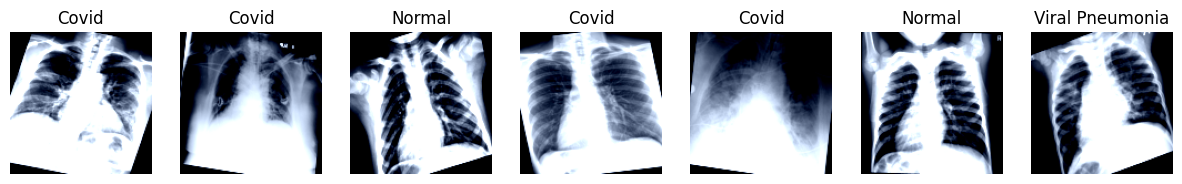

In [8]:
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

class_names = train_loader.dataset.dataset.classes
visualizeSamples(train_loader, class_names)

In [9]:
# Check data shape


# for batch_images, batch_class in train_loader:
#     print(batch_class)
#     print(batch_images.shape, batch_class.shape)

### CNN implementation

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5) # dropout to enhance result
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv7(x))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.dropout(x) # dropout implementation
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Train my model

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # L2-regularization

    best_val_acc = 0.0
    best_epoch = 0
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        epoch_train_losses.append(running_loss / len(train_loader))
        epoch_train_accuracies.append(train_acc)

        val_acc, val_loss = evaluate_model(model, val_loader, device)
        epoch_val_losses.append(val_loss)
        epoch_val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")

    plot_metrics(epoch_train_losses, epoch_val_losses, epoch_train_accuracies, epoch_val_accuracies)

    return model

In [12]:
def evaluate_model(model, val_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = running_loss / len(val_loader)

    return val_acc, val_loss

In [13]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Train and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [14]:
def load_best_model(model, device='cpu'):
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    model = model.to(device)
    
    return model

In [15]:
def test_model(model, test_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_loss = running_loss / len(test_loader)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Epoch [1/10], Loss: 1.0999, Train Acc: 39.30%, Val Acc: 50.00%, Val Loss: 1.0824, Time: 26.76s
Epoch [2/10], Loss: 1.1113, Train Acc: 42.79%, Val Acc: 50.00%, Val Loss: 1.0868, Time: 24.42s
Epoch [3/10], Loss: 1.0091, Train Acc: 42.79%, Val Acc: 50.00%, Val Loss: 0.7584, Time: 25.89s
Epoch [4/10], Loss: 1.1012, Train Acc: 37.81%, Val Acc: 38.00%, Val Loss: 1.0942, Time: 26.44s
Epoch [5/10], Loss: 1.0109, Train Acc: 41.79%, Val Acc: 50.00%, Val Loss: 0.8318, Time: 25.84s
Epoch [6/10], Loss: 0.8525, Train Acc: 51.74%, Val Acc: 48.00%, Val Loss: 0.7284, Time: 24.55s
Epoch [7/10], Loss: 0.8832, Train Acc: 56.22%, Val Acc: 48.00%, Val Loss: 0.8131, Time: 24.43s
Epoch [8/10], Loss: 0.7915, Train Acc: 60.20%, Val Acc: 54.00%, Val Loss: 0.6720, Time: 25.38s
Epoch [9/10], Loss: 0.7572, Train Acc: 62.19%, Val Acc: 54.00%, Val Loss: 0.5929, Time: 24.27s
Epoch [10/10], Loss: 0.7163, Train Acc: 59.20%, Val Acc: 58.00%, Val Loss: 0.7172, Time: 24.37s


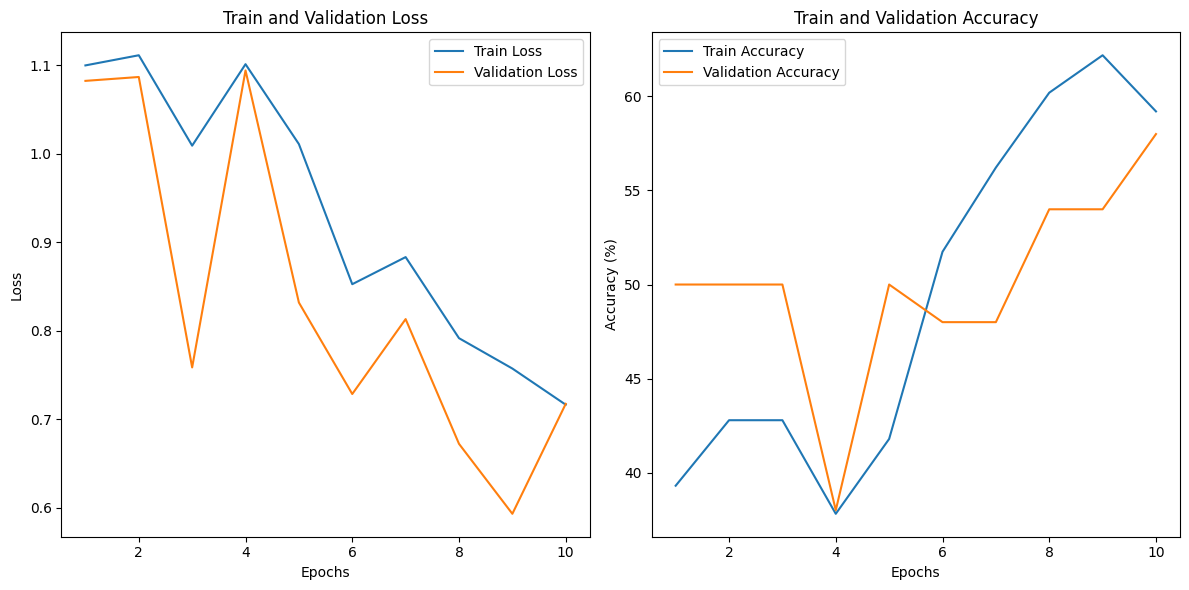

In [16]:
my_cnn = CNN(num_classes=3)
trained_model = train_model(my_cnn, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, device='cpu')

### Print metrics of my implementation of CNN

In [17]:
best_model = load_best_model(my_cnn, device='cpu')
test_model(best_model, test_loader, device='cpu')

Test Loss: 0.7274
Test Accuracy: 74.24%
Precision: 0.7762
Recall: 0.7424
F1 Score: 0.7511


### Import pretrained models (ResNet & EfficientNet) and train them

In [18]:
import timm
from transformers import ResNetForImageClassification

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

EfficientNet

In [20]:
efficientnet = timm.create_model('tf_efficientnet_b0', pretrained=True)

num_features = efficientnet.classifier.in_features  # Получаем количество входных признаков
efficientnet.classifier = nn.Linear(num_features, 3)  # Заменяем на один выходной нейрон

In [23]:
efficientnet_criterion = nn.CrossEntropyLoss()

In [25]:
efficientnet_optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)

In [21]:
efficientnet_train_loader, efficientnet_val_loader, efficientnet_test_loader = getDataLoaders(main_path, batch_size=32)

In [22]:
def train_efficientnet_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for inputs, one_hot_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)
        
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for inputs, one_hot_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
                labels = torch.argmax(one_hot_labels, dim=1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_efficientnet.pth')  # Сохраняем лучшую модель
        else:
            counter += 1
            if counter >= patience:
                print("Ранняя остановка сработала")
                break

In [26]:
train_efficientnet_model(efficientnet, efficientnet_train_loader, efficientnet_val_loader, efficientnet_criterion, efficientnet_optimizer, num_epochs=10)

Epoch 1/10 (Val): 100%|██████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


Epoch 1/10
Train Loss: 0.6734, Train Acc: 0.7272
Val Loss: 0.4938, Val Acc: 0.8819


Epoch 2/10 (Val): 100%|██████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


Epoch 2/10
Train Loss: 0.2813, Train Acc: 0.8948
Val Loss: 0.1626, Val Acc: 0.9722


Epoch 3/10 (Val): 100%|██████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


Epoch 3/10
Train Loss: 0.3924, Train Acc: 0.8854
Val Loss: 0.4456, Val Acc: 0.7639


Epoch 4/10 (Val): 100%|██████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


Epoch 4/10
Train Loss: 0.1241, Train Acc: 0.9464
Val Loss: 0.4051, Val Acc: 0.8663


Epoch 5/10 (Val): 100%|██████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

Epoch 5/10
Train Loss: 0.1726, Train Acc: 0.9306
Val Loss: 0.1962, Val Acc: 0.9688
Ранняя остановка сработала


In [27]:
def test_efficientnet_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.load_state_dict(torch.load('best_efficientnet.pth'))
    model.eval()

    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, one_hot_labels in tqdm(test_loader, desc="Testing"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [28]:
test_efficientnet_model(efficientnet, efficientnet_test_loader, efficientnet_criterion)

Testing: 100%|███████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]

Test Loss: 0.2056, Test Acc: 0.9479


ResNet

In [29]:
resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

resnet_num_features = resnet.classifier[1].in_features 
resnet.classifier[1] = nn.Linear(resnet_num_features, 3)

In [30]:
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [31]:
resnet_train_loader, resnet_val_loader, resnet_test_loader = getDataLoaders(main_path, batch_size=32)

In [32]:
def train_resnet_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for inputs, one_hot_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs).logits  # ResNet возвращает словарь, используем .logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)
        
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for inputs, one_hot_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
                labels = torch.argmax(one_hot_labels, dim=1)
                outputs = model(inputs).logits  # ResNet возвращает словарь, используем .logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_resnet.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Ранняя остановка сработала")
                break

In [33]:
train_resnet_model(resnet, resnet_train_loader, resnet_val_loader, resnet_criterion, resnet_optimizer, num_epochs=10)

Epoch 1/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


Epoch 1/10
Train Loss: 1.0521, Train Acc: 0.3934
Val Loss: 0.9515, Val Acc: 0.7326


Epoch 2/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


Epoch 2/10
Train Loss: 0.7830, Train Acc: 0.6602
Val Loss: 0.8149, Val Acc: 0.7917


Epoch 3/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


Epoch 3/10
Train Loss: 0.5715, Train Acc: 0.8770
Val Loss: 0.5483, Val Acc: 0.8194


Epoch 4/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


Epoch 4/10
Train Loss: 0.3752, Train Acc: 0.9038
Val Loss: 0.3204, Val Acc: 0.8819


Epoch 5/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


Epoch 5/10
Train Loss: 0.2077, Train Acc: 0.9261
Val Loss: 0.1783, Val Acc: 0.9253


Epoch 6/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


Epoch 6/10
Train Loss: 0.1591, Train Acc: 0.9241
Val Loss: 0.2434, Val Acc: 0.9410


Epoch 7/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


Epoch 7/10
Train Loss: 0.0952, Train Acc: 0.9643
Val Loss: 0.1587, Val Acc: 0.9288


Epoch 8/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


Epoch 8/10
Train Loss: 0.2042, Train Acc: 0.9187
Val Loss: 0.1515, Val Acc: 0.9566


Epoch 9/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


Epoch 9/10
Train Loss: 0.1199, Train Acc: 0.9598
Val Loss: 0.3953, Val Acc: 0.8472


Epoch 10/10 (Val): 100%|█████████████████████████| 2/2 [00:03<00:00,  1.87s/it]

Epoch 10/10
Train Loss: 0.1981, Train Acc: 0.9439
Val Loss: 0.4115, Val Acc: 0.8264


In [34]:
def test_resnet_model(model, test_loader, criterion):
    device = torch.device("cpu")
    model = model.to(device)
    model.load_state_dict(torch.load('best_resnet.pth'))
    model.eval()

    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, one_hot_labels in tqdm(test_loader, desc="Testing"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            
            labels = torch.argmax(one_hot_labels, dim=1)
            
            # Forward pass
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            
            # Считаем метрики
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [35]:
test_resnet_model(resnet, resnet_test_loader, resnet_criterion)

Testing: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]

Test Loss: 0.0961, Test Acc: 0.9688


### Как мы видим наивысший test accuracy у модели microsoft/resnet50